In [44]:
library(Quandl)
library(ggplot2)
library(zoo)
library(fBasics)

Quandl.api_key("vVPRRRiSWG3RxCPMupfa")
Xraw <- Quandl('EOD/SIVR',start_date='2013-12-2',end_date='2015-12-31')
Yraw <- Quandl('EOD/SLV',start_date='2013-12-2',end_date='2015-12-31')

Date <- rev(Xraw$Date)
Xclose <- rev(Xraw$Adj_Close)
Yclose <- rev(Yraw$Adj_Close)
Xvolume <- rev(Xraw$Adj_Volume)
Yvolume <- rev(Yraw$Adj_Volume)

In [45]:
## parameters
M <- 6
g <- 0.0001
j <- 0.0001
s <- 0.07

In [46]:
## calculate volume and capital
N <- rollmedian(Xvolume*Xclose,15)
K <- max(N)*2

## shares of X & Y
Xshare <- round(N/(100*Xclose[15:length(Xclose)]))
Yshare <- round(Xshare*Xclose[15:length(Xclose)]/Yclose[15:length(Yclose)])

## M-day return of X & Y
Xreturn <- diff(Xclose,M)/Xclose[1:(length(Xclose)-M)]
Yreturn <- diff(Yclose,M)/Yclose[1:(length(Yclose)-M)]

## calculate spread
spread <- Xreturn-Yreturn

## first day and the last day of a month
firstDay=function(x)
{           
  x=as.Date(as.character(x))
  DD = format(x,format="%d")
  MMYY = format(x,format="%Y-%m")
  y = tapply(DD,MMYY, min)
  first=as.Date(paste(row.names(y),y,sep="-"))
}
lastDay=function(x)
{           
  x=as.Date(as.character(x))
  DD = format(x,format="%d")
  MMYY = format(x,format="%Y-%m")
  y = tapply(DD,MMYY, max)
  last=as.Date(paste(row.names(y),y,sep="-"))
}

firstday<-firstDay(Date)
lastday<-lastDay(Date)

In [47]:
## combine data
if(M<=14)
{
  Date<-Date[15:length(Date)]
  Xclose<-Xclose[15:length(Xclose)]
  Yclose<-Yclose[15:length(Yclose)]
  spread<-spread[(15-M):length(spread)]
}
if(M>14)
{
  Date<-Date[(M+1):length(Date)]
  Xclose<-Xclose[(M+1):length(Xclose)]
  Yclose<-Yclose[(M+1):length(Yclose)]
  Xshare<-Xshare[(M-13):length(Xshare)]
  Yshare<-Yshare[(M-13):length(Yshare)]
}

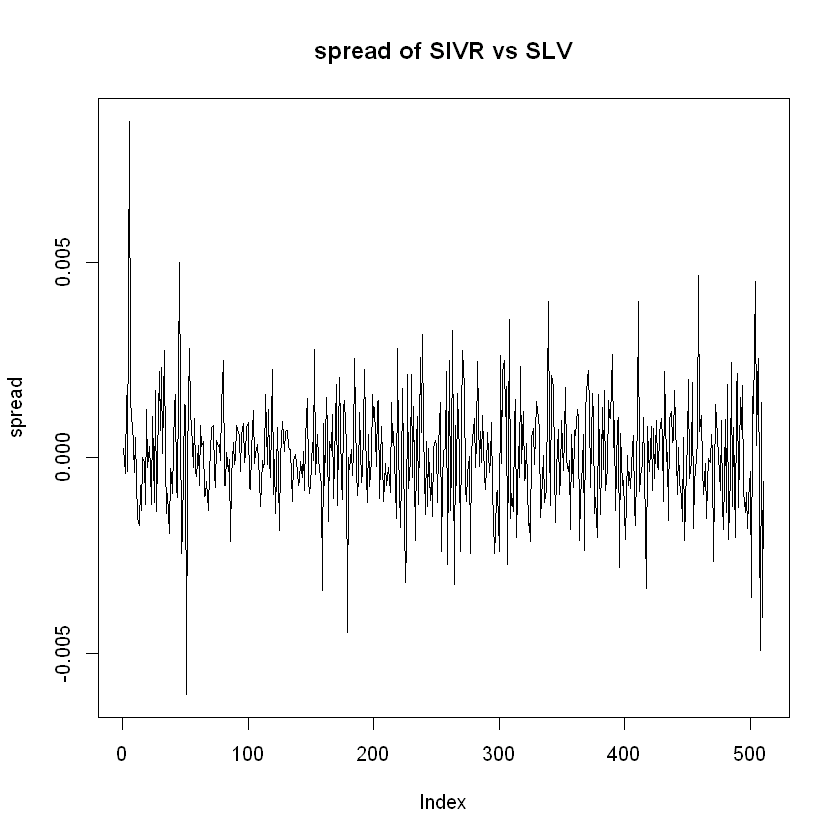

[1] 3885.443

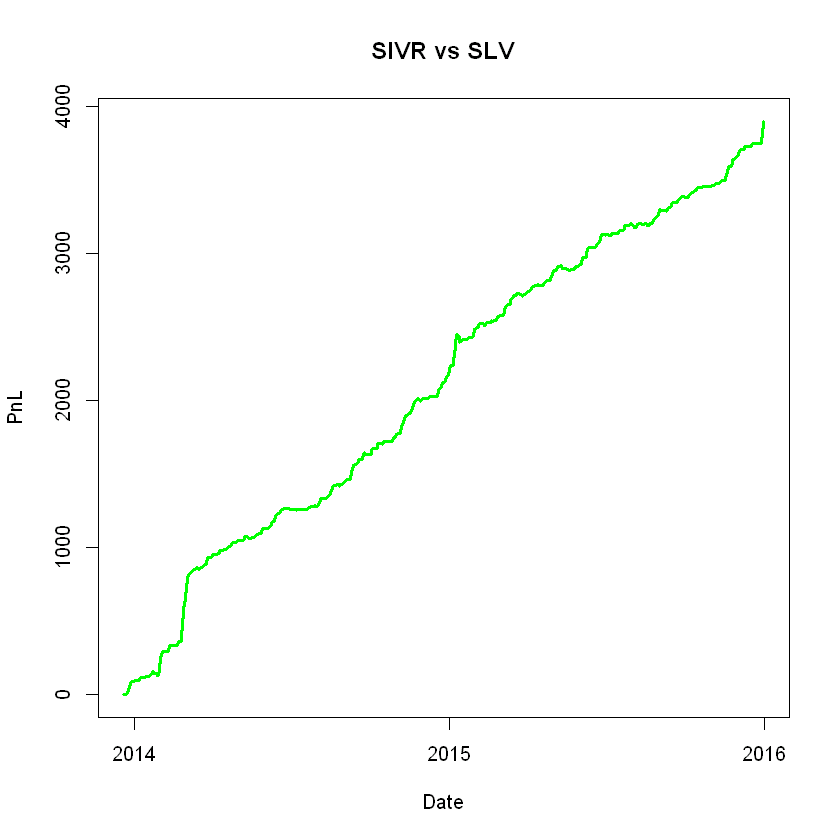

In [48]:
## construct trading strategy

pnl=rep(0,length(Date)+1)
value=0
cash=rep(0,length(Date))
loss=rep(0,length(Date))
position=0
Xposition=0
Yposition=0

for(i in 1:length(Date))
{
  if(position==0)
  {
    if(spread[i]>=g)## long
    {
      Xposition=-Xshare[i]
      Yposition=Yshare[i]
      value=Xshare[i]*Xclose[i]+Yshare[i]*Yclose[i] ## write entry
      cost=Xshare[i]*Xclose[i]-Yshare[i]*Yclose[i]
      position=1 ## new position
    }
    else if(spread[i]<=-g)## short
    {
      Xposition=Xshare[i]
      Yposition=-Yshare[i]
      value=Xshare[i]*Xclose[i]+Yshare[i]*Yclose[i]
      cost=Xshare[i]*Xclose[i]-Yshare[i]*Yclose[i]
      position=-1
    }
  }
  else if(position==1)
  {
    loss[i]=1-(Yposition*Yclose[i]-Xposition*Xclose[i])/value
    if(any(Date[i]==lastday))
    {
      cash[i]=Yposition*Yclose[i]+Xposition*Xclose[i]-cost ##short
      position=0
    }
    else
    {
      if(loss[i]>=s)         ##force rebalance
      {
        cash[i]=Yposition*Yclose[i]+Xposition*Xclose[i]-cost
        position=0
      }
      else
      {
        if(spread[i]<=j && spread[i]>=-g)
        {
          cash[i]=Yposition*Yclose[i]+Xposition*Xclose[i]-cost          ##short
          position=0
        }
        else if(spread[i]<=-g)          ##rebalance and short
        {
          cash[i]=Yposition*Yclose[i]+Xposition*Xclose[i]-cost
          value=Xshare[i]*Xclose[i]+Yshare[i]*Yclose[i]
          cost=Xshare[i]*Xclose[i]-Yshare[i]*Yclose[i]
          Xposition=Xshare[i]
          Yposition=-Yshare[i]
          position=-1
        }
        else
        {
          cash[i]=0
          position=1
        }
      }
    }
  }
  else
  {
    loss[i]=1-(Xposition*Xclose[i]-Yposition*Yclose[i])/value
    
    if(any(Date[i]==lastday))      ##long
    {
      cash[i]=Xposition*Xclose[i]+Yposition*Yclose[i]-cost
      position=0
    }
    else
    {
      if(loss[i]>=s)        ##force rebalance
      {
        cash[i]=Xposition*Xclose[i]+Yposition*Yclose[i]-cost
        position=0
      }
      else
      {
        if(spread[i]>=-j && spread[i]<=g)          ##long
        {
          cash[i]=Xposition*Xclose[i]+Yposition*Yclose[i]-cost
          position=0
        }
        else if(spread[i]>=g)          ##rebalance and long
        {
          cash[i]=Xposition*Xclose[i]+Yposition*Yclose[i]-cost
          value=Xshare[i]*Xclose[i]+Yshare[i]*Yclose[i]
          cost=Xshare[i]*Xclose[i]-Yshare[i]*Yclose[i]
          Xposition=-Xshare[i]
          Yposition=Yshare[i]
          position=1
        }
      }
    }
  }
  pnl[i+1]=pnl[i]+cash[i]
}
plot(spread,type='l', main="spread of SIVR vs SLV")
plot(Date,pnl[1:length(Date)],xlab="Date",ylab="PnL",main="SIVR vs SLV",type="l", col="green", lwd=3)
pnl[length(pnl)]

Variable Analysis:

M:

M <- 3 g <- 0.0001 j <- 0.0001 s <- 0.07 = 3353.60

M <- 6 g <- 0.0001 j <- 0.0001 s <- 0.07 = 3885.44 (best)

M <- 9 g <- 0.0001 j <- 0.0001 s <- 0.07 = 3645.83

g:

M <- 6 g <- 0.0001 j <- 0.0001 s <- 0.07 = 3885.44 (best)

M <- 6 g <- 0.0002 j <- 0.0001 s <- 0.07 = 3642.47

M <- 6 g <- 0.0005 j <- 0.0001 s <- 0.07 = 3601.14

j:

M <- 6 g <- 0.0001 j <- 0.0001 s <- 0.07 = 3885.44 (best)

M <- 6 g <- 0.0001 j <- 0.0002 s <- 0.07 = 3797.94

M <- 6 g <- 0.0001 j <- 0.0005 s <- 0.07 = 3846.11

s:

M <- 6 g <- 0.0001 j <- 0.0002 s <- 0.01 = 3436.92

M <- 6 g <- 0.0001 j <- 0.0002 s <- 0.03 = 3654.02

M <- 6 g <- 0.0001 j <- 0.0002 s <- 0.07 = 3885.44 (best)

Conclusion:

This ETF pair is sensitive to trading window as a smaller M increases the executions of trading but also increase in potential fees and lose the opportunity to gain more spread; picking M too large however loses the chance to catch more volatile spread within short period.

As indicated by the spread plot, values of g-j do not pose big influences on the strategy since the spreads are mostly "small", so choose g,j small would be preferrable.

The s factor terminates the strategy when it goes into designated loss, but since the spread in this case is relatively small, choose s larger would gain most spreads without exposing to too much risk.